In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import sqrt

import DataAid
import Neros

In [27]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

# chi squared function
def chiSquared(observed, expected, error):
    chiSquared = 0
    
    for i in range(len(observed)):
        chiSquared = chiSquared + (((observed[i] - expected[i])**2) / (error[i]**2))
        
    return chiSquared / len(observed)

# Fit function
def simple(independents, alpha, vLumFreeParam):
    # Parse out data for the galaxy
    rad,vLum = independents
    # Apply the vLum free param to the data
    vLum = vLum*vLumFreeParam
    # Calc vLCM with alpha free param
    vLcm = Neros.vLcm(rad, MW_vLum_interp_func(rad), vLum)
    # Calc and return vNeros
    return Neros.vNeros(vLum, vLcm, alpha)

## Create the Milky Way interpolation function

In [28]:
MW_rad = MWXueSofue[:,0]
MW_vLum = MWXueSofue[:,1]
# Interpolation function
MW_vLum_interp_func = interp1d(MW_rad, MW_vLum, kind='cubic')

## Running VNeros on every galaxy
We calculate vNeros for each galaxy and then plot the ratio between vNeros and the galaxy's vObs

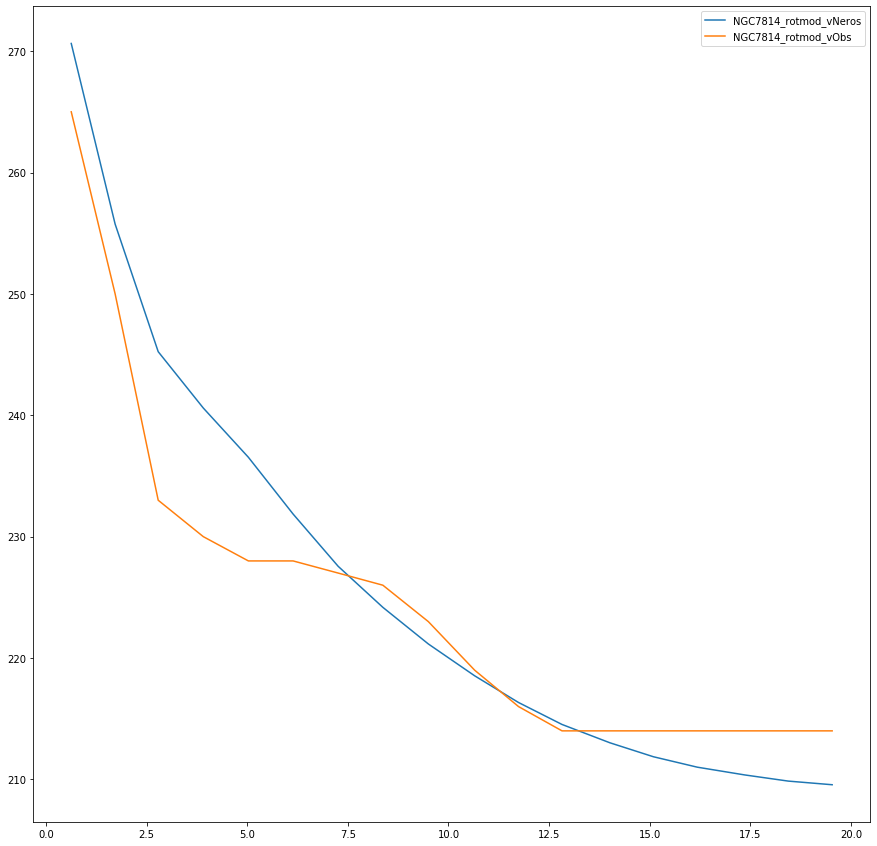

In [29]:
vLcmList = []
f, ax = plt.subplots(1, figsize=(15,15))
for galaxyName in sparcGalaxies:
    # change the name in "" to print only that galaxy
    if (galaxyName != "NGC7814_rotmod"):
        continue
    
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
    
    # fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_vLum),galaxy_vObs)
    fittedAlpha, fittedVLumFreeParam = vals
    # vExpected = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam)
    
    # chiSquare = chiSquared(galaxy_vObs, vExpected, galaxy_error)
    
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum )
    vLcmList.append(vLcm)
    vNeros = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam)
    ratio = vNeros/galaxy_vObs
    
    # plot
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
ax.legend(loc="upper right")

## Fitting Galaxies

In [30]:
file = open('imported-data/data.csv', 'w')
file.write('{0},{1},{2}\n'.format("Galaxy", "Alpha", "vLum"))
   
# Parse out data

for galaxyName in sparcGalaxies:
    # change the name in "" to print only that galaxy
    if (galaxyName != "NGC3953_rotmod"):
        continue
    
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break

    # Run fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_vLum),galaxy_vObs)
    fittedAlpha, fittedVLumFreeParam = vals
    vExpected = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam)
    
    chiSquare = chiSquared(galaxy_vObs, vExpected, galaxy_error)
    
    print('{0},{1},{2},{3}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam, chiSquare))
    file.write('{0},{1},{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))

NGC3953_rotmod,112.8661225520611,0.9080097074169665,0.4534968263810521

